## Tutorial

PyPXR is designed to tackle reflectivity datasets measured over many eneriges and polarizations. This process is analogous to changing contrast in Neutron reflectivity that provides more information about a given system. Co-refinement of multiple datasets is essential to achieve a unique solution with PyPXR.

This tutorial will guide you through the basic steps to build and subsequently refine a slab model to fit polarized reflectivity of a glassy thin film. It is recommended that you are familiar with modeling reflectivity from hard X-rays or neutrons prior to polarized X-ray reflectivity. An excellent example can be found in the 'Getting Started' section within the *refnx* documentation.

### Creating a model

Load the necessary packages for PyPXR modeling

In [1]:
%matplotlib inline

import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py

#sys.path.append("C:/Users/tjf2/Documents/GitHub/P-RSoXR/PyPXR")
sys.path.append("../../../src/PyPXR")

#from ani_reflect.ani_reflect_model import *
#from ani_reflect.ani_structure import *

from anisotropic_reflectivity import *
from anisotropic_structure import *

PyPXR builds a `PXR_Structure` by combining `PXR_Slab` objects into a vertical stack and calculates the expected specular reflectivity given an incident energy and polarization. Individual slabs are composed of a material bounded by two interfaces. Each material is defined through its complex tensor index of refraction, $n(E) = 1-\delta(E) + i \beta(E)$. $\delta$ and $\beta$ are proportional to the real and imaginary scattering length densities and can either be a scalar or a tensor. PyPXR uses conventions in soft X-ray science so all optical parameters are defined in terms of $n(E)$.

The begin every model, we first need to define the materials within our sample. The easiest way to do this is by using the `PXR_SLD` object (for resonant isotropic/anisotropic materials) and the `PXR_MaterialSLD` object (for non-resonant materials). *Note:* many objects in PyPXR are similarly named to the equivalent refnx object to help aleviate any learning curve.

`PXR_SLD` is ideal when materials are resonant with the chosen photon energy and dielectric function cannot be referenced with *PeriodicTable*. Objects will be assigned a complex tensor index of refraction defined with the extraordinary axis perpdindicular to the substrate and ordinary axis parallel with the substrate.

`PXR_MaterialSLD` is for materials that are not resonant with the chosen photon energy. This option is commonly used to define substrates and superstrates. It uses *PeriodicTable* to determine $n(E)$. *This function requires an explicit photon energy.*

In [2]:
en = 284.4 #[eV]

si = PXR_MaterialSLD('Si', density=2.33, energy=en, name='Si') #Substrate
sio2 = PXR_MaterialSLD('SiO2', density=2.28, energy=en, name='SiO2') #Substrate
vacuum = PXR_MaterialSLD('', density=1, energy=en, name='vacuum') #Superstrate
n_xx = complex(-0.00033, 0.000113) # [unitless] #Ordinary Axis
n_zz = complex(-0.0004, 0.00028) # [unitless] #Extraordinary Axis
posa = PXR_SLD(np.array([n_xx, n_zz]), name='posaconazole') #Molecule

In this example, our thin film is composed of a vapor deposited glassy thin film on a silicon substrate. We are going to assume our film is uniaxial in the laboratory frame and only defined by ``n_xx`` and ``n_zz``.

We can now build multiple `PXR_Slab` objects using our newly defined materials. Physical dimensions include thickness and surface roughness (both in Angstroms). Currently, the only interface that is supported is a Nevot-Croce roughness and the input corresponds to the width of an error function.

In [3]:
#Substrate objects
#(thickness, roughness)
si_slab = si(0, 0.5) #thickness of bounding substrate does not matter
sio2_slab = sio2(12, 1)
#Film bulk
posa_slab = posa(711, 0.5)

Our composite ``PXR_Structure`` can now be generated by combining each`PXR_Slab` with the following convention.

*structure = Superstrate | top layer | mid layers | ... | bottom layer | Substrate*

In [4]:
structure = vacuum | posa_slab | sio2_slab | si_slab

The current model can be viewed with the `structure.plot()` function. The resulting plot will give a summary of the complex tensor components as a function of depth from the film surface. Setting `difference=True` provides a complimentary plot of the film birefringence: ($\delta_{xx} - \delta_{zz}$) and the dichroism: ($\beta_{xx} - \beta_{zz})$.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

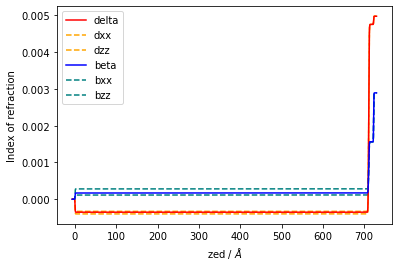

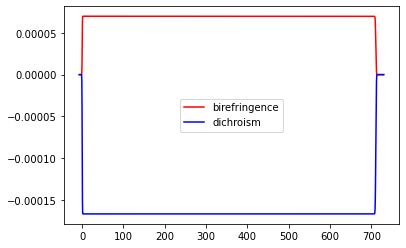

In [5]:
structure.plot(difference=True)

Note that in addition to the individual components, the *delta* and *beta* profiles correspond to the normalized trace of the dielectric tensor. This is equivalent to the components of an *isotropic* material
$$\delta = \frac{2\delta_{xx} + \delta_{zz}}{3}$$
$$\beta = \frac{2\beta_{xx} + \beta_{zz}}{3}$$

### Calculating polarized X-ray reflectivity

Now that we have a preliminary model, we can define an X-ray probe through the `PXR_ReflectModel` object.

In [6]:
model_spol = PXR_ReflectModel(structure, energy=en, pol='s', name=('spol'))
model_ppol = PXR_ReflectModel(structure, energy=en, pol='p', name=('ppol'))

`PXR_ReflectModel` requires two additional inputs to specify the incident X-rays: `pol` is used to define the linear polarization state, and `en` is used to specify the photon energy. Any ``PXR_Slab`` or ``PXR_MaterialSLD`` that requires an input photon energy will be updated at this time. It is not necessary to create a substrate object for each energy you wish to fit.

We can plot each profile given the input model and a set of q-values to take a measurement.

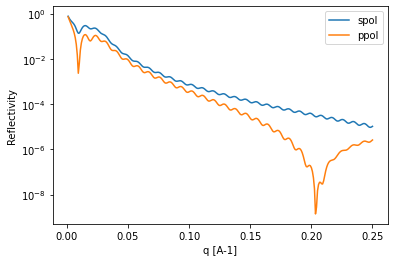

In [7]:
qvals = np.linspace(0.001, 0.25, 300)
plt.plot(qvals, model_spol(qvals), label='spol')
plt.plot(qvals, model_ppol(qvals), label='ppol')
plt.yscale('log')
plt.ylabel('Reflectivity')
plt.xlabel('q [A-1]')
plt.legend()

Success! The plot above gives the expected specular reflectivity of our input structure based on the incident polarization. Note the difference in reflectance at low angles, this is a result of the uniaxial response

### Fitting data

Now that we have a model, we want to use it to fit some real data. PyPXR utilizes the refnx package for all fitting and requires the following imports.

In [8]:
from refnx.dataset import ReflectDataset # Object used to define data
from refnx.analysis import Transform, CurveFitter, Objective # For fitting

An example set of data can be downloaded from the GitHub repository.

In [9]:
mypath = "../../../src/PyPXR/example_data/"
mypath_s = os.path.join(mypath, 'Feb19_Exp101_p100.txt')  # s-pol data
mypath_p = os.path.join(mypath, 'Feb19_Exp101_p190.txt')  # p-pol data

mydata_s = np.genfromtxt(mypath_s, delimiter='\t')
mydata_p = np.genfromtxt(mypath_p, delimiter='\t')

To help speed up the fitting process, we will concatenate our data to fit both polarizations simultaneously.

In [10]:
mydata = np.concatenate([mydata_s, mydata_p]) # Concatenate data
data = ReflectDataset(mydata.T) # Transpose to set the axis correctly
model = PXR_ReflectModel(structure, energy=en, pol='sp') # Model that outputs a concatenated result

Data is combined with a model in the form of an ``Objective``.

In [11]:
objective = Objective(model, data, transform=Transform('logY'))

Objectives can be quickly plotted to get a sense of how well your initial model agrees with the data

Text(0.5, 0, 'q [A-1]')

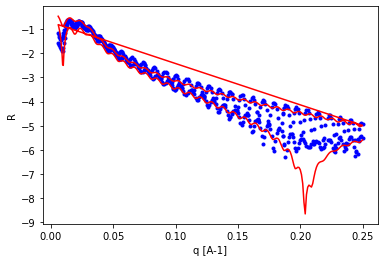

In [12]:
objective.plot()
plt.ylabel('R')
plt.xlabel('q [A-1]')

Oh no! Our initial model looks like it could use some improvements. 

As it turns out, our data does not exhibit any indication of Brewsters angle at $\approx0.2A^-1$. This is an indication that our structure may be more complicated than a single layer model. Lets add an additional layer to the surface and remodel the data, we can always remove it later. 

In [13]:
#Make the new index of refraction
n2_xx = complex(-0.0004, 0.000627) # [unitless] #Ordinary Axis
n2_zz = complex(-0.0005, 0.000003) # [unitless] #Extraordinary Axis
posa_surface = PXR_SLD(np.array([n2_xx, n2_zz]), name='material2') #Molecule
posa_surface_slab = posa_surface(15,1)

#Reinitialize the model functions
structure = vacuum | posa_surface_slab | posa_slab | sio2_slab | si_slab
model = PXR_ReflectModel(structure, energy=en, pol='sp')
objective = Objective(model, data, transform=Transform('logY'))

Text(0.5, 0, 'q [A-1]')

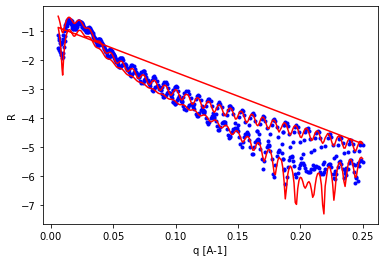

In [14]:
objective.plot()
plt.ylabel('R')
plt.xlabel('q [A-1]')

Much better! While our model clearly needs some refinement, its initial structure is not too far off from the data.

To begin fitting, we need to setup the parameters that we want to vary. This uses the ``Parameter`` functionality within *refnx*

Each object that we have created has several optional parameters

`PXR_Slab`
 - Thickness : ('thick')
 - Roughness : ('rough')
 
`PXR_MaterialSLD`
 - Density : ('density')
 
`PXR_Slab`
 - ordinary component of delta : ('xx and yy')
 - extraordinary component of delta : ('zz')
 - ordinary component of beta : ('ixx and iyy')
 - extraordinary component of beta : ('izz')
 - *Optional parameters:*
     - normalized trace of delta : ('diso')
     - normalized trace of beta : ('biso')
     - Birefringence : ('birefringence')
     - Dichroism : ('dichroism')

Optional parameters allow for alternative parameterizations through constraints. Only 'xx', 'yy', 'zz', 'ixx', 'iyy', and 'izz' are physically used in the calculation.

In [15]:
# Substrates
si_slab.thick.setp(vary=False)
si_slab.rough.setp(vary=False, bounds=(1,2))

sio2_slab.thick.setp(vary=True, bounds=(5,20))
sio2_slab.rough.setp(vary=True, bounds=(2,10))
sio2_slab.sld.density.setp(vary=False)

# The default tensor symmetry is for uniaxial materials.
# This automatically sets constraints for xx = yy and ixx = iyy
posa_slab.thick.setp(vary=True, bounds=(400,900))
posa_slab.rough.setp(vary=True, bounds=(0.2,20))
posa_slab.sld.xx.setp(vary=True, bounds=(-0.00001, -0.01))
posa_slab.sld.zz.setp(vary=True, bounds=(-0.00001, -0.01))
posa_slab.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_slab.sld.izz.setp(vary=True, bounds=(0, 0.01))

posa_surface_slab.thick.setp(vary=True, bounds=(5,30))
posa_surface_slab.rough.setp(vary=True, bounds=(0.5,20))
posa_surface_slab.sld.xx.setp(vary=True, bounds=(-0.00001, -0.001))
posa_surface_slab.sld.zz.setp(vary=True, bounds=(-0.00001, -0.001))
posa_surface_slab.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_surface_slab.sld.izz.setp(vary=True, bounds=(0, 0.01))


A composite list of open parameters can be examined by looking at the `Objective.varying_parameters()`

In [16]:
print(objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'material2_thick', value=15          , bounds=[5.0, 30.0]>
<Parameter:'material2_xx' , value=-0.0004          , bounds=[-0.001, -1e-05]>
<Parameter:'material2_ixx', value=0.000627          , bounds=[0.0, 0.01]>
<Parameter:'material2_zz' , value=-0.0005          , bounds=[-0.001, -1e-05]>
<Parameter:'material2_izz', value=3e-06          , bounds=[0.0, 0.01]>
<Parameter:'material2_rough', value=1          , bounds=[0.5, 20.0]>
<Parameter:'posaconazole_thick', value=711          , bounds=[400.0, 900.0]>
<Parameter:'posaconazole_xx', value=-0.00033          , bounds=[-0.01, -1e-05]>
<Parameter:'posaconazole_ixx', value=0.000113          , bounds=[0.0, 0.01]>
<Parameter:'posaconazole_zz', value=-0.0004          , bounds=[-0.01, -1e-05]>
<Parameter:'posaconazole_izz', value=0.00028          , bounds=[0.0, 0.01]>
<Parameter:'posaconazole_rough', value=0.5          , bounds=[

Our final step is to create a ``CurveFitter`` by using the ``Objective``

In [26]:
fitter = CurveFitter(objective)

Running a fit will envoke an `emcee` sampler object. Details on the exact algorithm can be found with the *emcee* documentation. For now, we will simply use the default *StretchMove* to run our fit.

In this example:

    1) We begin by running 1500 samples in order to find the local minima.
    2) Once we have reached the minima, we will reset our chain to discard all samples that were taken outside the minima. 
    3) We finish by running 1000 samples within the final minima.

In [28]:
chain = fitter.sample(1500)
fitter.reset()
chain = fitter.sample(1000)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:24<00:00,  2.60it/s]


We can now check on our results by replotting the updated `Objective`

Text(0.5, 0, 'q [A-1]')

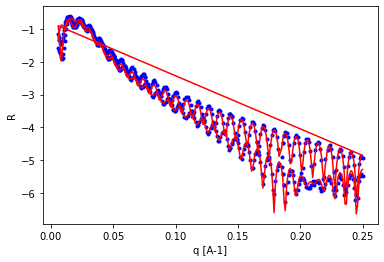

In [29]:
objective.plot()
plt.ylabel('R')
plt.xlabel('q [A-1]')

Looks great! What about the orientation depth profile?

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='zed / $\\AA$', ylabel='Index of refraction'>)


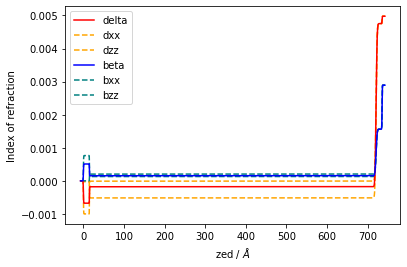

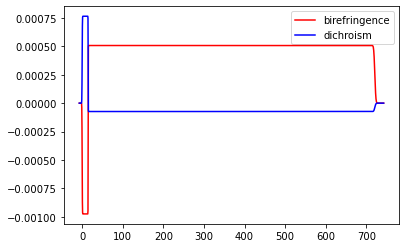

In [30]:
print(objective.model.structure.plot(difference=True))

So we found that our best fit model has a highly oriented surface layer and less oriented bulk.

We can now check on the final parameters

In [31]:
print(objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'material2_thick', value=14.8522 +/- 0.0329, bounds=[5.0, 30.0]>
<Parameter:'material2_xx' , value=-0.000999903 +/- 1.19e-07, bounds=[-0.001, -1e-05]>
<Parameter:'material2_ixx', value=0.00076375 +/- 2.8e-06, bounds=[0.0, 0.01]>
<Parameter:'material2_zz' , value=-2.6469e-05 +/- 1.98e-06, bounds=[-0.001, -1e-05]>
<Parameter:'material2_izz', value=8.83313e-08 +/- 1.23e-07, bounds=[0.0, 0.01]>
<Parameter:'material2_rough', value=0.5049 +/- 0.00596, bounds=[0.5, 20.0]>
<Parameter:'posaconazole_thick', value=705.909 +/- 0.0185, bounds=[400.0, 900.0]>
<Parameter:'posaconazole_xx', value=-1.00218e-05 +/- 2.7e-08, bounds=[-0.01, -1e-05]>
<Parameter:'posaconazole_ixx', value=0.000129838 +/- 2.3e-07, bounds=[0.0, 0.01]>
<Parameter:'posaconazole_zz', value=-0.000516445 +/- 4.97e-07, bounds=[-0.01, -1e-05]>
<Parameter:'posaconazole_izz', value=0.000203417 +/- 2.64e-07, bounds=[0.